In [1]:
from gym import Env 
from gym import spaces 
from IPython.display import clear_output
import random 
import numpy as np 
import random
import pprint
import matplotlib.pyplot as plt

In [2]:
# global constants

# game board values
NOTHING = 0
WINDOW = 1
# states
CHANGE = 2
NO_CHANGE= 3
# action values
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

NUM_ACTIONS = 4

# game board size
BOARD_SIZE = 6


In [3]:
def generate_user_profile(num_env_states, base_change_probability_range, lambda_fatigue_range, num_actions=4):
    user_profile = []
    user_lambda_fatigue = np.random.uniform(*lambda_fatigue_range)
    
    for _ in range(num_env_states):
        state_probabilities = []
        for _ in range(num_actions):
            base_change_probability_state = np.random.uniform(*base_change_probability_range)
            state_probabilities.append(base_change_probability_state)
        user_profile.append(state_probabilities)
    
    return user_profile, user_lambda_fatigue

def generate_all_users_profile(num_users, base_change_probability_range, lambda_fatigue_range):
    all_users_profiles = []
    all_users_lambda_fatigue = []
    
    for _ in range(num_users):
        user_profile, user_lambda_fatigue = generate_user_profile(36, base_change_probability_range, lambda_fatigue_range)
        all_users_profiles.append(user_profile)
        all_users_lambda_fatigue.append(user_lambda_fatigue)
    
    return all_users_profiles, all_users_lambda_fatigue
    
class User():
    def __init__(self, user_profile, lambda_fatigue):
        self._user_profile = user_profile
        self._lambda_fatigue = lambda_fatigue
        self._step_count = 0

    def fatigue_adjusted(self):
        return 1 - np.exp(-self._lambda_fatigue * self._step_count)
    
    def change_state(self, state, action, previous_action):
        fatigue = self.fatigue_adjusted()
        adjusted_change_probability = self._user_profile[state][action] * (1 - fatigue)
        self._step_count += 1
        if np.random.uniform(0, 1) <= adjusted_change_probability:
            return CHANGE
        else:
            return NO_CHANGE


In [4]:
class ScreenEnv(Env):
    def __init__(self, user, max_iter=200):
        # custom class variable used to display the reward earned
        self.cumulative_reward = 0
        self.iter_number = 0
        self.max_iter = max_iter
        #
        # set the initial state to a flattened 6x6 grid with a randomly
        # placed window
        #
        self.state = [NOTHING] * 36
        self.window_position = 4
        self.user_state = NO_CHANGE
        self.user = user
        
        self.state[self.window_position] = WINDOW
        # convert the python array into a numpy array 
        self.state = np.array(self.state, dtype=np.int16)
        # observation space (valid ranges for observations in the state)
        self.observation_space = spaces.Box(0, 3, [36,], dtype=np.int16)
        # valid actions:
        #   0 = up
        #   1 = down
        #   2 = left
        #   3 = right
        self.action_space = spaces.Discrete(5)

    def is_valid_action(self, action):
        if action == UP:
            return (self.window_position - 6) >= 0
        elif action == DOWN:
            return (self.window_position + 6) < 36
        elif action == LEFT:
            return (self.window_position % 6) != 0
        elif action == RIGHT:
            return (self.window_position % 6) != 5
        return False
    
    def step(self, action):
        # placeholder for debugging information
        info = {}
        # set default values for done, reward, and the window position
        # before taking the action
        done = False
        reward = 0

        if self.iter_number >= self.max_iter:
            done = True
            return self.state, reward, done, info, True

        previous_position = self.window_position

        # take the action by moving the user
        if self.is_valid_action(action):
            if action == UP:
                self.window_position -= 6
            elif action == DOWN:
                self.window_position += 6
            elif action == LEFT:
                self.window_position -= 1
            elif action == RIGHT:
                self.window_position += 1
            self.iter_number += 1
        else:
            return self.state, reward, done, info, False

        # give the state of user
        self.user_state = self.user.change_state(previous_position, action, self.user_state)

        # set reward based on the user's state
        if self.user_state == CHANGE:
            reward = 1.0
        elif self.user_state == NO_CHANGE:
            reward = -1.0
        else:
            reward = 0.0  # Default reward for other cases

        # Update the environment state
        if not done:
            # update the window position
            self.state[previous_position] = NOTHING
            self.state[self.window_position] = WINDOW

        self.cumulative_reward += reward

        return self.state, reward, done, info, True
    
    def reset(self):
        self.cumulative_reward = 0
        self.iter_number = 0
        #
        # set the initial state to a flattened 6x6 grid with a randomly 
        # placed window
        #
        self.state = [NOTHING] * 36
        self.window_position = random.randrange(0, 36)
        
        self.state[self.window_position] = WINDOW
        # convert the python array into a numpy array 
        # (needed since Gym expects the state to be this way)
        self.state = np.array(self.state, dtype=np.int16)
        # print(f"Environment reset. Window Position: {self.window_position}")
        # pp = pprint.PrettyPrinter(indent=4)
        # reshaped_state = self.state.reshape(6, 6)
        # pp.pprint(reshaped_state)
        return self.state
    
    def render(self):
        pp = pprint.PrettyPrinter(indent=4)
        # pp.pprint({"state": self.state.reshape(6, 6), "cumulative_reward": self.cumulative_reward})


In [5]:
class DoubleQLearningAgent:
    def __init__(self, env, learning_rate=0.05, discount_factor=0.99, exploration_rate=0.2, exploration_decay=0.99):
        self.env = env
        self.q_table1 = np.zeros((36, env.action_space.n))
        self.q_table2 = np.zeros((36, env.action_space.n))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay

    def choose_action(self, state):
        state_index = self.get_state_index(state)
        if random.uniform(0, 1) < self.exploration_rate:
            action = self.env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(self.q_table1[state_index] + self.q_table2[state_index])  # Exploit learned values
        return action

    def learn(self, state, action, reward, next_state):
        state_index = self.get_state_index(state)
        next_state_index = self.get_state_index(next_state)
        
        if random.random() < 0.5:
            predict = self.q_table1[state_index, action]
            a_prime = np.argmax(self.q_table1[next_state_index])
            target = reward + self.discount_factor * self.q_table2[next_state_index, a_prime]
            self.q_table1[state_index, action] += self.learning_rate * (target - predict)
        else:
            predict = self.q_table2[state_index, action]
            a_prime = np.argmax(self.q_table2[next_state_index])
            target = reward + self.discount_factor * self.q_table1[next_state_index, a_prime]
            self.q_table2[state_index, action] += self.learning_rate * (target - predict)

    def update_exploration_rate(self):
        self.exploration_rate *= self.exploration_decay

    def get_state_index(self, state):
        # Convert the state representation to a single integer index if necessary
        return np.argmax(state)

    def get_policy(self):
        return np.argmax(self.q_table1 + self.q_table2, axis=1)

    def predict_reward(self, state, action):
        state_index = self.get_state_index(state)
        return (self.q_table1[state_index, action] + self.q_table2[state_index, action]) / 2


In [6]:
class ExpectedSARSAAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.99):
        self.env = env
        self.q_table = np.zeros((36, env.action_space.n))  # Adjust size based on state space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay

    def choose_action(self, state):
        state_index = self.get_state_index(state)
        if random.uniform(0, 1) < self.exploration_rate:
            action = self.env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(self.q_table[state_index])  # Exploit learned values
        return action

    def learn(self, state, action, reward, next_state):
        state_index = self.get_state_index(state)
        next_state_index = self.get_state_index(next_state)
        
        # Calculate expected Q-value for the next state
        policy = self.get_policy_for_state(next_state_index)
        expected_q = np.sum(policy * self.q_table[next_state_index])
        
        # Update rule for Expected SARSA
        target = reward + self.discount_factor * expected_q
        self.q_table[state_index, action] += self.learning_rate * (target - self.q_table[state_index, action])

    def update_exploration_rate(self):
        self.exploration_rate *= self.exploration_decay

    def get_state_index(self, state):
        # Convert the state representation to a single integer index if necessary
        return np.argmax(state)

    def get_policy(self):
        return np.argmax(self.q_table, axis=1)

    def get_policy_for_state(self, state_index):
        q_values = self.q_table[state_index]
        max_q_value = np.max(q_values)
        policy = np.zeros_like(q_values)
        count_max_q_values = np.sum(q_values == max_q_value)
        policy[q_values == max_q_value] = 1.0 / count_max_q_values
        return policy

    def predict_reward(self, state, action):
        state_index = self.get_state_index(state)
        return self.q_table[state_index, action]

In [7]:
# Function to calculate RMSE
def calculate_rmse(q_table1, q_table2):
    return np.sqrt(np.mean((q_table1 - q_table2) ** 2))

# Function to calculate rolling average
def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Function to train a Double Q-Learning agent
def train_double_q_learning_agent(env, learning_rate, exploration_rate, exploration_decay=0.99, episodes=10):
    agent = DoubleQLearningAgent(env, learning_rate, discount_factor=0.99, exploration_rate=exploration_rate, exploration_decay=exploration_decay)
    cumulative_rewards = []
    rmse_values = []

    cumulative_reward = 0
    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, info, valid = env.step(action)

            if not valid:
                continue  # If the action was invalid, choose another action

            agent.learn(state, action, reward, next_state)
            state = next_state

            # Update cumulative reward
            cumulative_reward += reward
            cumulative_rewards.append(cumulative_reward)

            # Calculate RMSE
            rmse = calculate_rmse(agent.q_table1, agent.q_table2)
            rmse_values.append(rmse)

        # Update exploration rate
        agent.update_exploration_rate()

    return cumulative_rewards, rmse_values

# Function to train a Double Q-Learning agent for multiple users, averaging results over multiple runs
def train_all_users_double_q_learning(num_users, learning_rate, exploration_rate, exploration_decay, episodes, runs=3):
    all_cumulative_rewards = []
    all_rmse_values = []

    for _ in range(num_users):
        cumulative_rewards_runs = []
        rmse_values_runs = []

        for _ in range(runs):
            # Initialize the environment and user profile here
            user_profile, lambda_fatigue = generate_user_profile(36, base_change_probability_range, lambda_fatigue_range)
            user = User(user_profile, lambda_fatigue)
            env = ScreenEnv(user, max_iter=10)
            
            # Train the agent
            cumulative_rewards, rmse_values = train_double_q_learning_agent(env, learning_rate, exploration_rate, exploration_decay, episodes)
            cumulative_rewards_runs.append(cumulative_rewards)
            rmse_values_runs.append(rmse_values)
        
        # Average the results over multiple runs
        avg_cumulative_rewards = np.mean(cumulative_rewards_runs, axis=0)
        avg_rmse_values = np.mean(rmse_values_runs, axis=0)
        all_cumulative_rewards.append(avg_cumulative_rewards)
        all_rmse_values.append(avg_rmse_values)
    
    return all_cumulative_rewards, all_rmse_values

In [8]:
# Function to train an Expected SARSA agent
def train_expected_sarsa_agent(env, learning_rate, exploration_rate, exploration_decay=0.99, episodes=10):
    agent = ExpectedSARSAAgent(env, learning_rate, discount_factor=0.99, exploration_rate=exploration_rate, exploration_decay=exploration_decay)
    cumulative_rewards = []

    cumulative_reward = 0
    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, info, valid = env.step(action)

            if not valid:
                continue  # If the action was invalid, choose another action

            agent.learn(state, action, reward, next_state)
            state = next_state

            # Update cumulative reward
            cumulative_reward += reward
            cumulative_rewards.append(cumulative_reward)

        # Update exploration rate
        agent.update_exploration_rate()

    return cumulative_rewards

# Function to train an Expected SARSA agent for multiple users, averaging results over multiple runs
def train_all_users_expected_sarsa(num_users, learning_rate, exploration_rate, exploration_decay, episodes, runs=3):
    all_cumulative_rewards = []

    for _ in range(num_users):
        cumulative_rewards_runs = []

        for _ in range(runs):
            # Initialize the environment and user profile here
            user_profile, lambda_fatigue = generate_user_profile(36, base_change_probability_range, lambda_fatigue_range)
            user = User(user_profile, lambda_fatigue)
            env = ScreenEnv(user, max_iter=10)
            
            # Train the agent
            cumulative_rewards = train_expected_sarsa_agent(env, learning_rate, exploration_rate, exploration_decay, episodes)
            cumulative_rewards_runs.append(cumulative_rewards)
        
        # Average the results over multiple runs
        avg_cumulative_rewards = np.mean(cumulative_rewards_runs, axis=0)
        all_cumulative_rewards.append(avg_cumulative_rewards)
    
    return all_cumulative_rewards

<h3> Implementation of Double Q-Learning with Fatigue</h3>

Perform a grid search to find the optimal parameters for this algorithm

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


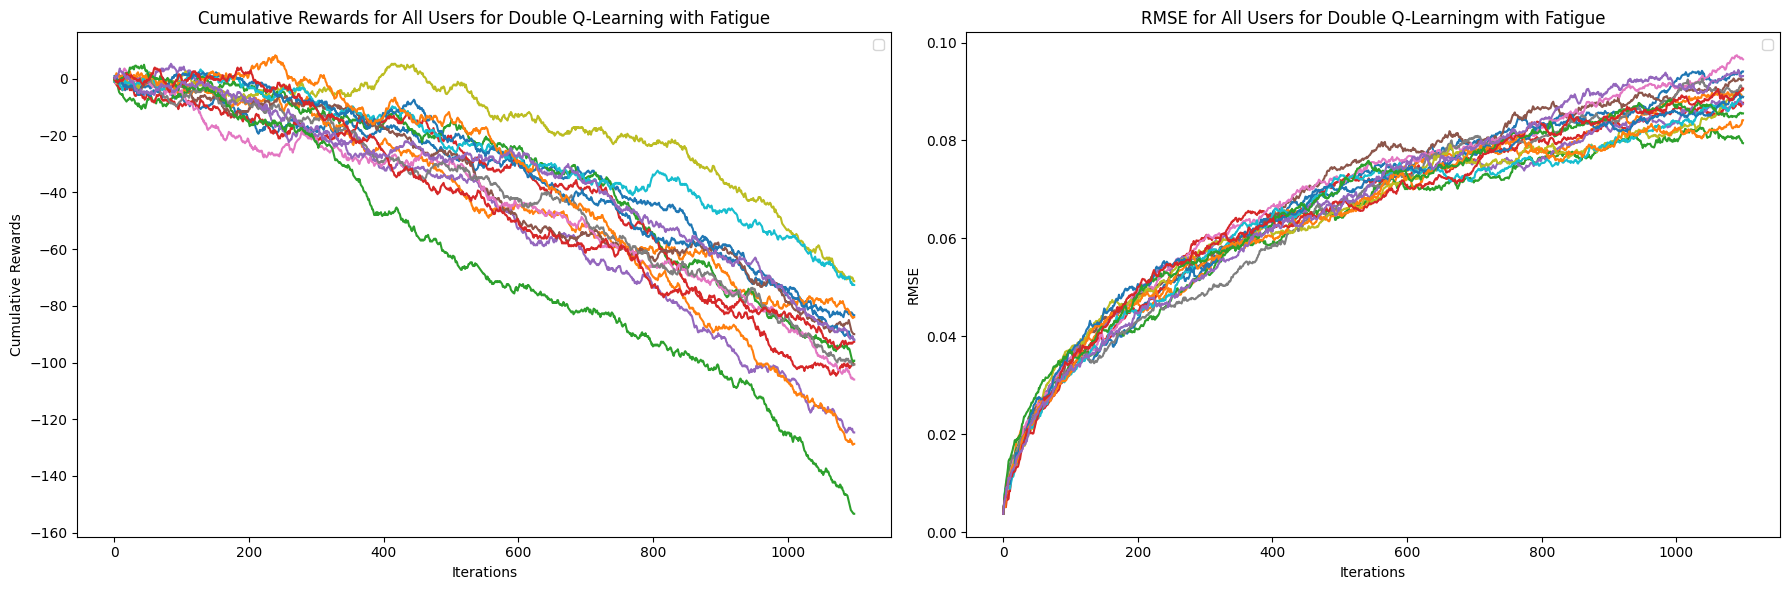

In [9]:
# Example usage
num_users = 15
learning_rate = 0.05
exploration_rate = 0.2
exploration_decay = 0.99
episodes = 100
base_change_probability_range = (0.3, 0.7)  # Example range, replace with actual range
lambda_fatigue_range = (0.0001, 0.0002)  # Example range, replace with actual range

all_cumulative_rewards_double_q, all_rmse_values_double_q = train_all_users_double_q_learning(num_users, learning_rate, exploration_rate, exploration_decay, episodes)

# Plot cumulative rewards and RMSE values for all users using Double Q-Learning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Cumulative Rewards Plot for Double Q-Learning
for i, rewards in enumerate(all_cumulative_rewards_double_q):
    ax1.plot(rewards)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Cumulative Rewards')
ax1.set_title('Cumulative Rewards for All Users for Double Q-Learning with Fatigue')
ax1.legend()

# RMSE Plot for Double Q-Learning
for i, rmse in enumerate(all_rmse_values_double_q):
    ax2.plot(rmse)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE for All Users for Double Q-Learningm with Fatigue')
ax2.legend()

plt.tight_layout()
plt.show()

<h3> Implementation of Expected SARSA with Fatigue</h3>

Perform a grid search to find the optimal parameters for this algorithm

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


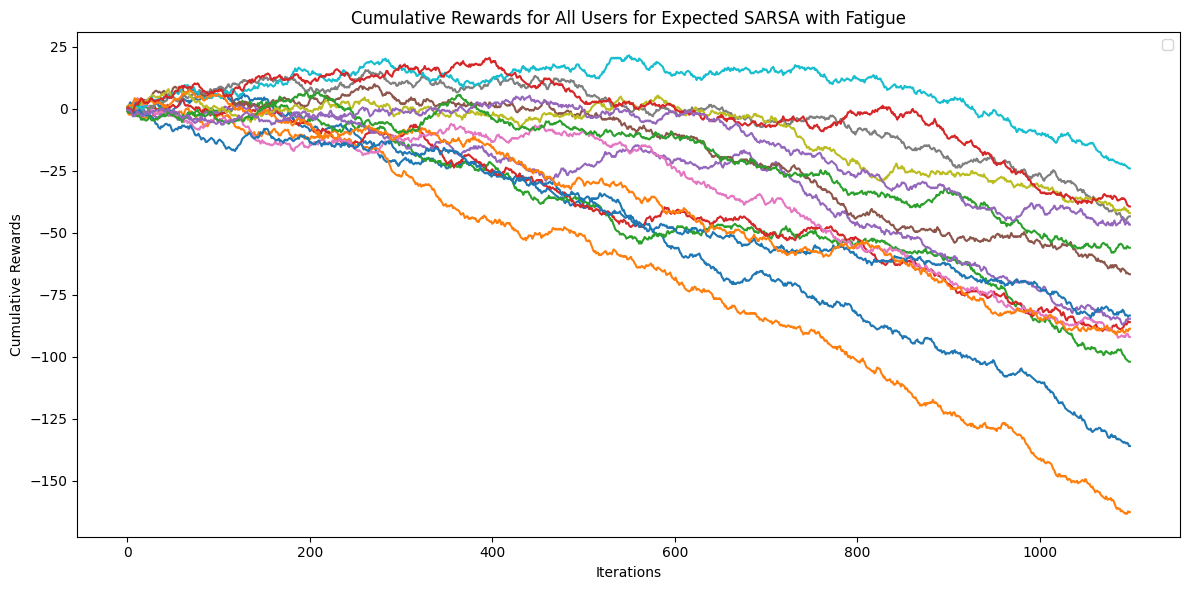

In [10]:
# Example usage
num_users = 15
learning_rate = 0.05
exploration_rate = 0.2
exploration_decay = 0.99
episodes = 100
base_change_probability_range = (0.3, 0.7)  # Example range, replace with actual range
lambda_fatigue_range = (0.0001, 0.0002)  # Example range, replace with actual range

all_cumulative_rewards_expected_sarsa = train_all_users_expected_sarsa(num_users, learning_rate, exploration_rate, exploration_decay, episodes)

# Plot cumulative rewards for all users using Expected SARSA
fig, ax1 = plt.subplots(figsize=(12, 6))

# Cumulative Rewards Plot for Expected SARSA
for i, rewards in enumerate(all_cumulative_rewards_expected_sarsa):
    ax1.plot(rewards)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Cumulative Rewards')
ax1.set_title('Cumulative Rewards for All Users for Expected SARSA with Fatigue')
ax1.legend()

plt.tight_layout()
plt.show()
